Solving a tractable consumption-savings model took 0.00242126476951 seconds.


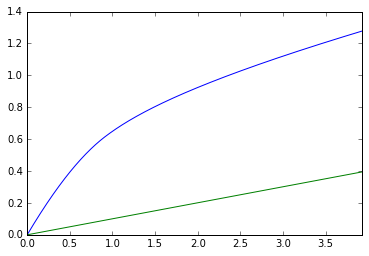

In [635]:
# %load TBSExamples.py
'''
This module runs an example version of the Tractable Buffer Stock model.
'''
# Import the HARK library.  The assumption is that this code is in a folder
# contained in the HARK folder.  Also import the ConsumptionSavingModel
import sys 
sys.path.insert(0,'../')
sys.path.insert(0,'../ConsumptionSavingModel')

from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import numpy as np
import TractableBufferStock as Model
from TractableBufferStock import GrowthImpatienceException, ReturnImpatienceException
from HARKutilities import plotFunc, plotFuncs
from ConsumptionSavingModel import ConsumerType, consumptionSavingSolverMarkov
from time import clock
import traceback
from repr import repr
import collections

import metacomm.combinatorics.all_pairs2
all_pairs = metacomm.combinatorics.all_pairs2.all_pairs2

# Define the model primitives
base_primitives = {'mho' : .015,
                   'beta' : 0.9,
                   'R' : 1.1,
                   'G' : 1.05,
                   'rho' : .95}

# Make and solve a tractable consumer type
ExampleType = Model.TractableConsumerType(**base_primitives)
t_start = clock()
ExampleType.solve()
t_end = clock()
print('Solving a tractable consumption-savings model took ' + str(t_end-t_start) + ' seconds.')

# Plot the consumption function and whatnot
m_upper = 1.5*ExampleType.m_targ
conFunc_PF = lambda m: ExampleType.h*ExampleType.kappa_PF + ExampleType.kappa_PF*m
#plotFuncs([ExampleType.solution[0].cFunc,ExampleType.mSSfunc,ExampleType.cSSfunc],0,m_upper)
plotFuncs([ExampleType.solution[0].cFunc,ExampleType.solution[0].cFunc_U],0,m_upper)

# Now solve the same model using backward induction
init_consumer_objects = {"rho":base_primitives['rho'],
                        "R":base_primitives['R'],
                        "Gamma":[base_primitives['G']/(1.0-base_primitives['mho'])],
                        "constraint":False,
                        "psi_sigma":[0.0],
                        "psi_N":1,
                        "xi_sigma":[0.0],
                        "xi_N":1,
                        "T_total":1,
                        "p_unemploy":0.0,
                        "p_unemploy_retire":0.0,
                        "T_retire":0,
                        "income_unemploy":0.0,
                        "income_unemploy_retire":0.0,
                        "a_min":0.001,
                        "a_max":ExampleType.m_max,
                        "a_size":16,
                        "a_extra":[None],
                        "exp_nest":3,
                        "survival_prob":[1.0],
                        "beta":[base_primitives['beta']],
                        'Nagents':1,
                        'psi_seed':0,
                        'xi_seed':0,
                        'unemp_seed':0,
                        'tax_rate':0.0,
                        'calc_vFunc':False,
                        'cubic_splines':True
                        }
MarkovType = ConsumerType(**init_consumer_objects)
transition_matrix = np.array([[1.0-base_primitives['mho'],base_primitives['mho']],[0.0,1.0]])
employed_income_dist = [np.ones(1),np.ones(1),np.ones(1)]
unemployed_income_dist = [np.ones(1),np.ones(1),np.zeros(1)]
p_zero_income = [np.array([0.0,1.0])]
MarkovType.solution_terminal.cFunc = 2*[MarkovType.solution_terminal.cFunc]
MarkovType.solution_terminal.vFunc = 2*[MarkovType.solution_terminal.vFunc]
MarkovType.solution_terminal.vPfunc = 2*[MarkovType.solution_terminal.vPfunc]
MarkovType.solution_terminal.vPPfunc = 2*[MarkovType.solution_terminal.vPPfunc]
MarkovType.solution_terminal.m_underbar = 2*[MarkovType.solution_terminal.m_underbar]
MarkovType.income_distrib = [[employed_income_dist,unemployed_income_dist]]
MarkovType.p_zero_income = p_zero_income
MarkovType.transition_matrix = transition_matrix
MarkovType.time_inv.append('transition_matrix')
MarkovType.solveAPeriod = consumptionSavingSolverMarkov
MarkovType.cycles = 0

t_start = clock()
MarkovType.solve()
t_end = clock()
MarkovType.unpack_cFunc()



In [636]:
def plotEmployedVsUnemployed(**base_primitives):
    ExampleTypeTest = Model.TractableConsumerType(**base_primitives)
    ExampleTypeTest.solve()
    m_upper = 1.5*ExampleTypeTest.m_targ
    plotFuncs([ExampleTypeTest.solution[0].cFunc,ExampleTypeTest.solution[0].cFunc_U],0,m_upper)
    
def plotStableArm(**base_primitives):
    ExampleTypeTest = Model.TractableConsumerType(**base_primitives)
    ExampleTypeTest.solve()
    m_upper = 1.5*ExampleTypeTest.m_targ
    plotFuncs([ExampleTypeTest.cSSfunc, ExampleTypeTest.mSSfunc,ExampleTypeTest.solution[0].cFunc],0,m_upper)
    
def plotDiffFunc(**base_primitives):
    ExampleTypeTest = Model.TractableConsumerType(**base_primitives)
    ExampleTypeTest.solve()
    diffFunc = lambda m : ExampleType.solution[0].cFunc(m) - MarkovType.cFunc[0][0](m)
    m_upper = 1.5*ExampleTypeTest.m_targ
    plotFunc(diffFunc,0,m_upper)
    
def graphingParams(base_primitives):
    mixMaxRangeTupples = {k:(v-2*v,v+2*v,v/50) for k,v in base_primitives.iteritems()}
    return mixMaxRangeTupples


    

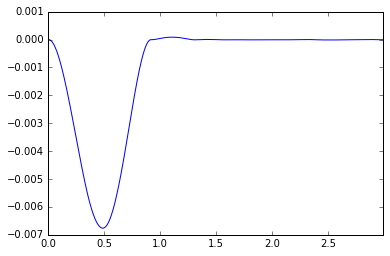

<function __main__.plotDiffFunc>

In [638]:
interact(plotDiffFunc,**graphingParams(base_primitives))

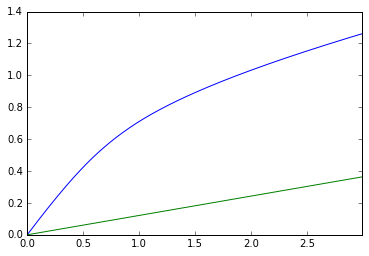

<function __main__.EmployedVsUnemployed>

In [639]:
interact(EmployedVsUnemployed, **graphingParams(base_primitives))

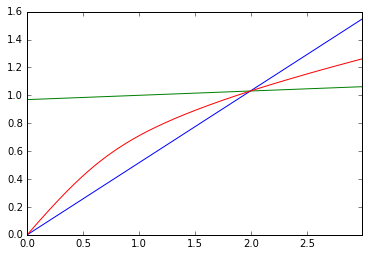

<function __main__.StableArm>

In [640]:
interact(StableArm, 
         **graphingParams(base_primitives))

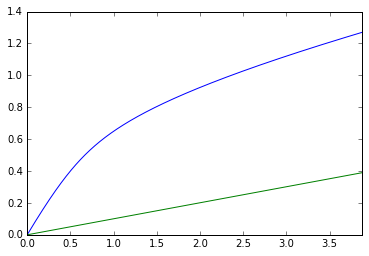

In [643]:
interact(plotFuncs,bottom=0,top=m_upper,FunctionList={'ConsumptionFunctions':MarkovType.cFunc[0]},N=fixed(1000))